-------------------------------------------------------------------


## **Nyquists samplingssats**

En bandbegränsad signal $x(t)$ med största frekvens $B$ Hz kan
återskapas exakt från sina sampel om den samplas med en frekvens
$f_s > 2B$. Detta kallas **Nyquistfrekvensen**: $f_N = 2B$.

## **Shannon–Whittaker interpolation**

Om $x(t)$ är bandbegränsad till $|f| < B$, så kan den återskapas från
sina sampel $x[n] = x(nT)$ (där $T = 1/f_s$) via: $$
x(t) = \sum_{n=-\infty}^{\infty} x[n] \cdot \text{sinc}\left( \frac{t - nT}{T} \right)
$$ där $\text{sinc}(u) = \frac{\sin(\pi u)}{\pi u}$.

## **Poissons summationsformel**

$$
\sum_{n=-\infty}^{\infty} x(nT) e^{-i 2\pi f nT} = \frac{1}{T} \sum_{k=-\infty}^{\infty} X\left(f - \frac{k}{T}\right)
$$ Det vill säga: **Fouriertransformen av ett samplat signal
(impulståg)** är en **periodisk upprepning** av spektrat $X(f)$ med
period $f_s = 1/T$.


-------

-----------------------------------------------------------------

# **Python-övning**


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 1. Parametrar
# -------------------------------
B = 5.0                     # Bandbredd i Hz
fs_list = [12.0, 10.0, 8.0] # Olika samplingsfrekvenser (fs > 2B = 10 => fs=12 OK, fs=10 kritisk, fs=8 undersampling)
T_cont = 2.0                # Tidsintervall för "kontinuerlig" signal [-T_cont, T_cont]
N_cont = 2000               # Antal punkter för kontinuerlig approximation
t_cont = np.linspace(-T_cont, T_cont, N_cont)
dt_cont = t_cont[1] - t_cont[0]
df_cont = 1 / (N_cont * dt_cont)
f_cont = np.fft.fftfreq(N_cont, d=dt_cont)
f_cont = np.fft.fftshift(f_cont)

In [3]:
# -------------------------------
# 2. Skapa bandbegränsad signal x(t)
# -------------------------------
# Amplitudspektrum: |X(f)| = 1 - (f/B)^2 för |f| < B, annars 0
X_f = np.where(np.abs(f_cont) < B, 1 - (f_cont / B)**2, 0)

# Slumpmässig fas (uniform [-π, π])
np.random.seed(42)
phase = np.random.uniform(-np.pi, np.pi, size=X_f.shape)
X_complex = X_f * np.exp(1j * phase)

# Invers Fouriertransform för att få x(t)
x_t = np.fft.ifft(np.fft.ifftshift(X_complex)) * N_cont * df_cont  # Skalning för kontinuerlig FT
x_t = np.real(x_t)  # Signalen bör vara reell (fas slumpad symmetriskt, men vi tar realdel för säkerhet)

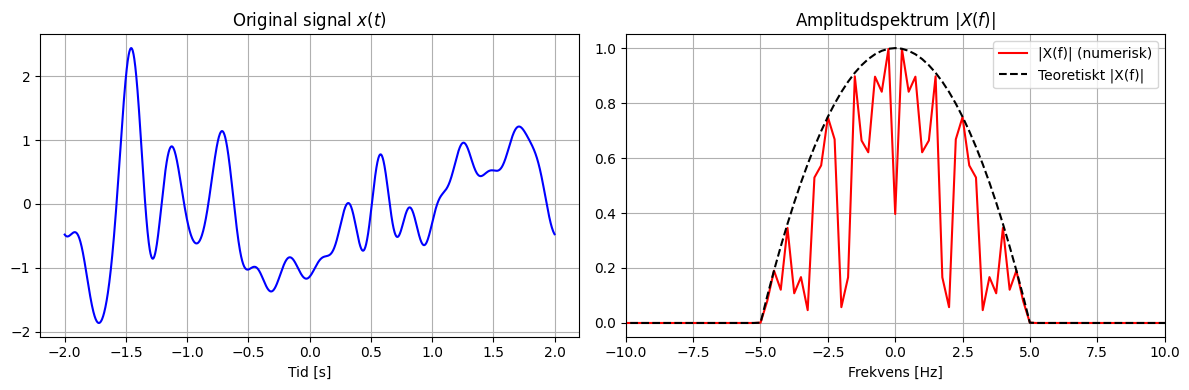

In [4]:
# -------------------------------
# 3. Plotta originalsignal och spektrum
# -------------------------------
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(t_cont, x_t, 'b', label='x(t)')
plt.title('Original signal $x(t)$')
plt.xlabel('Tid [s]')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(f_cont, np.abs(np.fft.fftshift(np.fft.fft(x_t)/N_cont/df_cont)), 'r', label='|X(f)| (numerisk)')
plt.plot(f_cont, X_f, 'k--', label='Teoretiskt |X(f)|')
plt.title('Amplitudspektrum $|X(f)|$')
plt.xlabel('Frekvens [Hz]')
plt.xlim(-2*B, 2*B)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
# -------------------------------
# 4. Hjälpfunktioner
# -------------------------------
def sha_train(t, T):
    """Impulståg (Dirac-kam) med period T – approximeras med nära noll"""
    n = np.round(t / T).astype(int)
    impulses = np.isclose(t, n * T, atol=dt_cont/2)
    return impulses.astype(float) / dt_cont  # Skalning för att approximera delta

def dirichlet_kernel(f, N, T):
    """Dirichlet-kärnan: D_N(f) = sin(pi N f T) / (N sin(pi f T))"""
    # Undvik division med noll
    eps = 1e-12
    denom = np.sin(np.pi * f * T)
    denom = np.where(np.abs(denom) < eps, eps, denom)
    return np.sin(np.pi * N * f * T) / (N * denom)

def sinc_interp(t, t_samples, x_samples, T):
    """Shannon-Whittaker interpolation"""
    # Broadcasting: t är (M,), t_samples är (N,)
    t = t[:, None]  # (M, 1)
    t_samples = t_samples[None, :]  # (1, N)
    return np.sum(x_samples * np.sinc((t - t_samples) / T), axis=1)

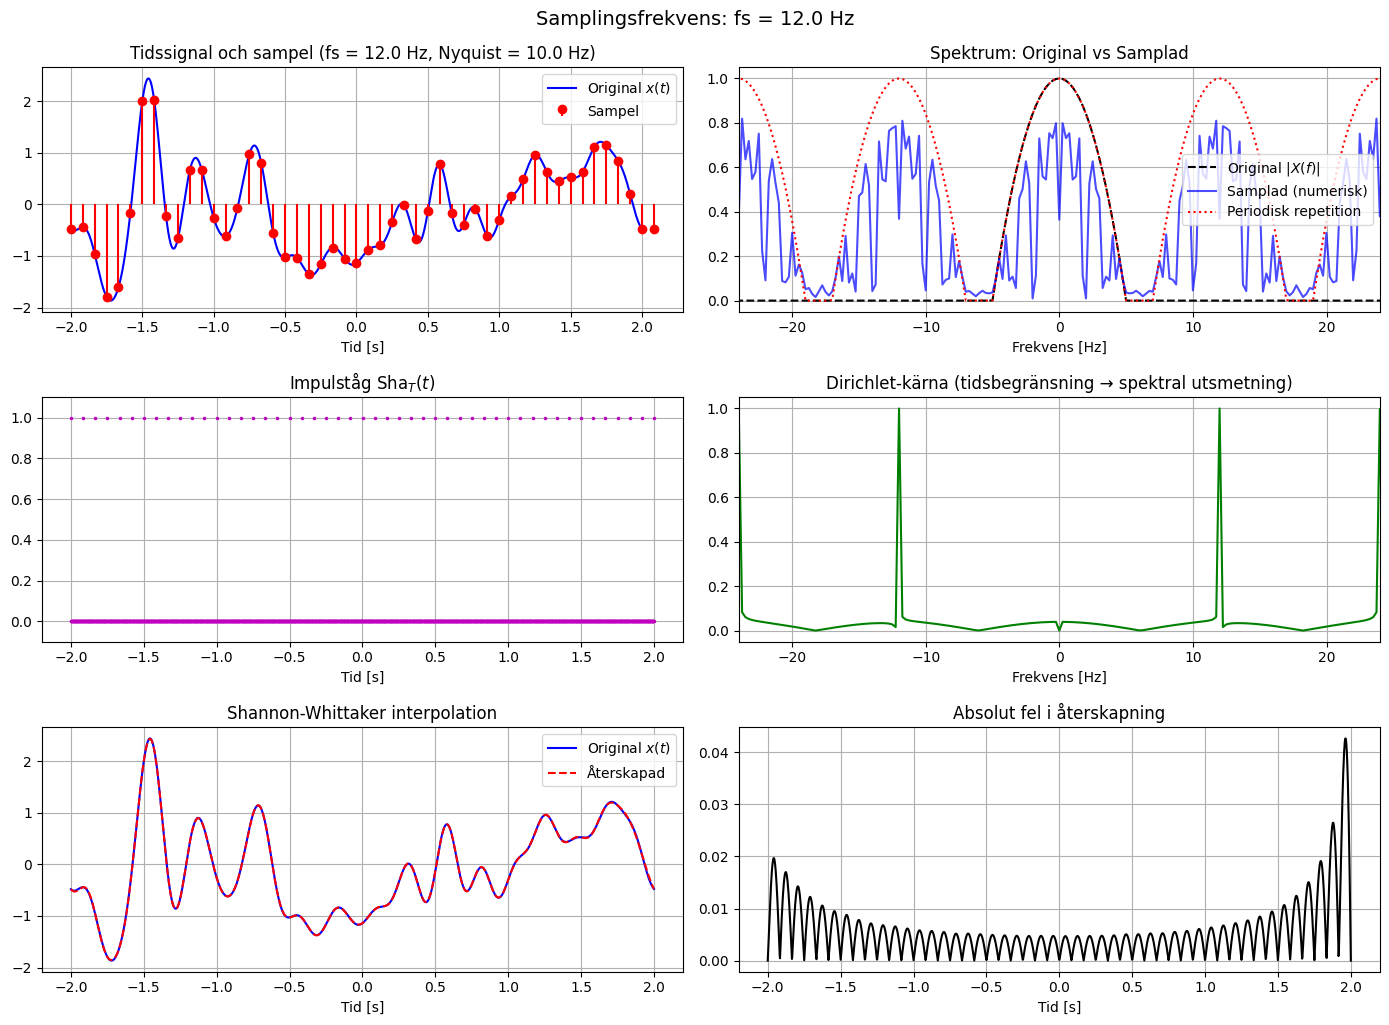

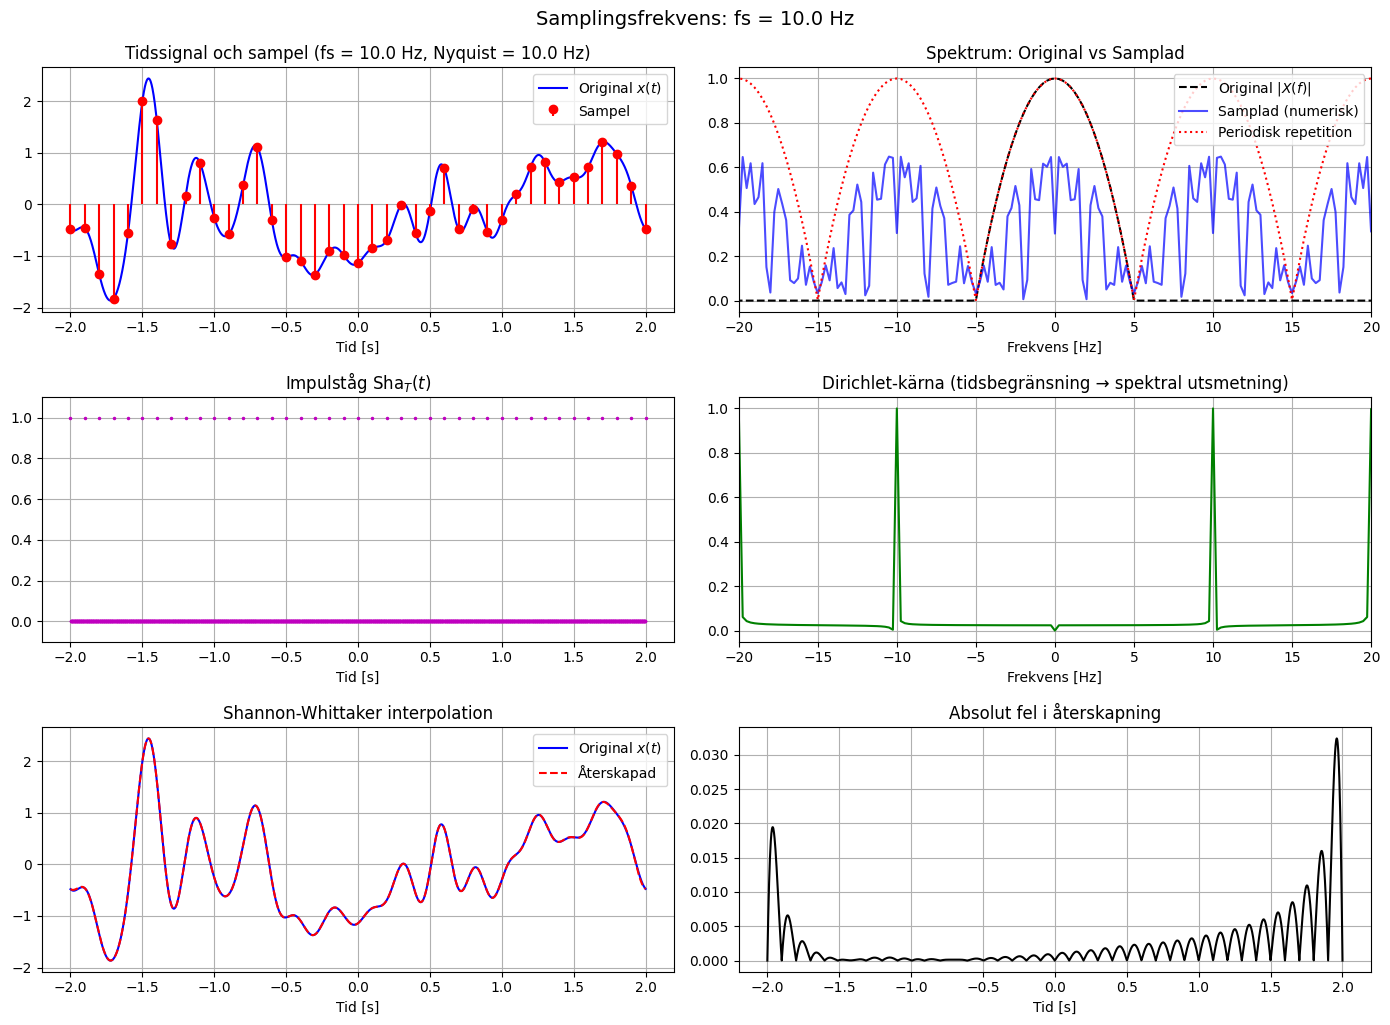

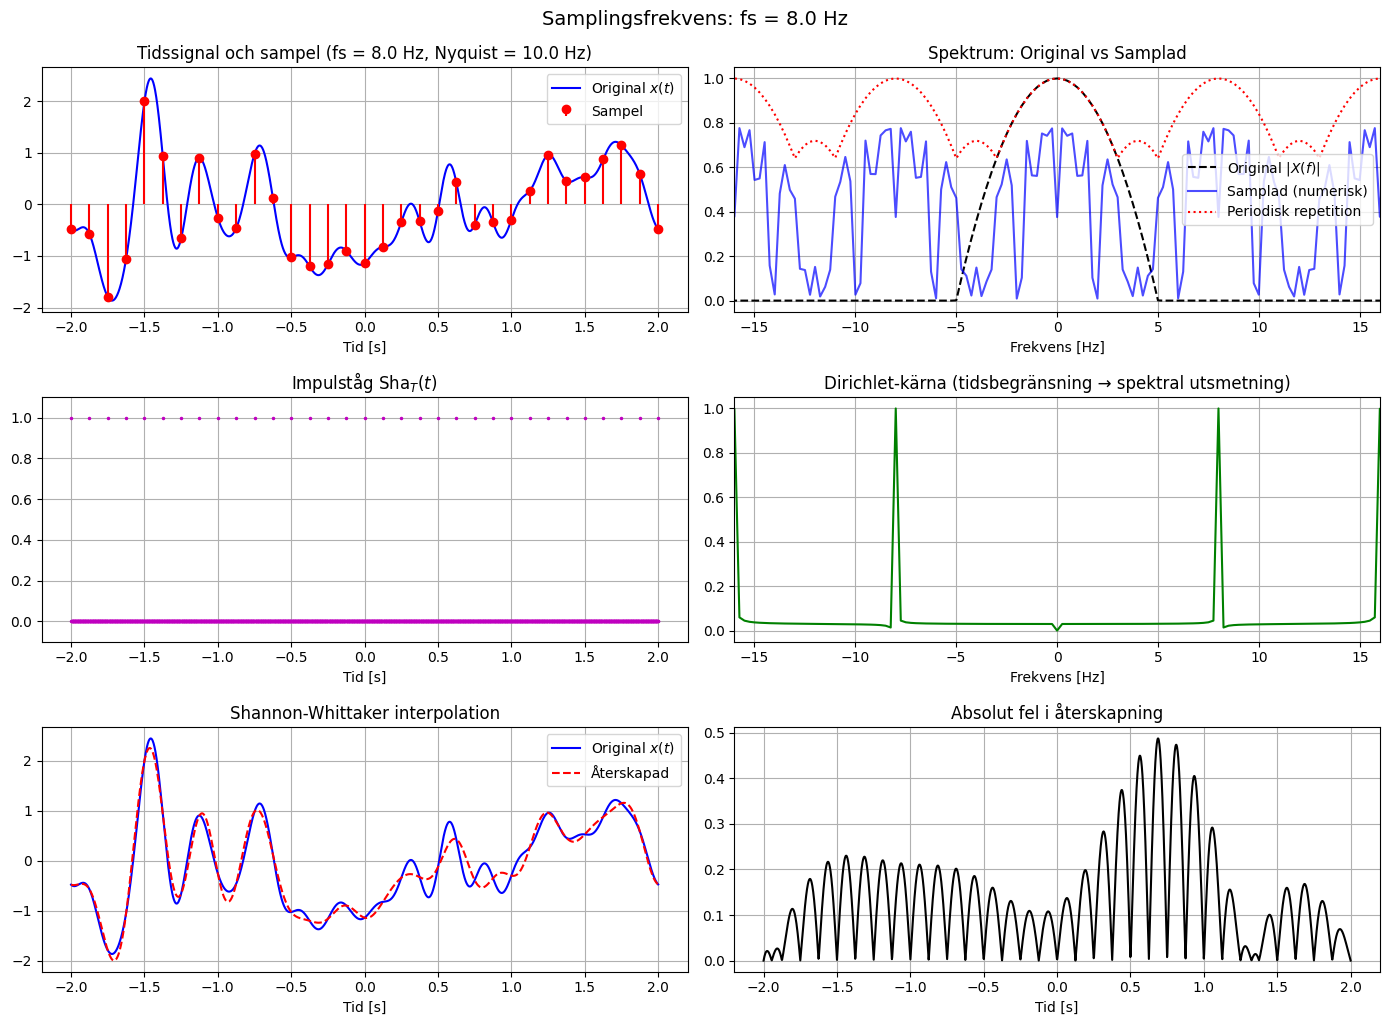

In [8]:
# -------------------------------
# 5. Loop över olika samplingsfrekvenser
# -------------------------------
for fs in fs_list:
    T = 1.0 / fs
    # Sampel i samma intervall som t_cont
    t_samples = np.arange(-T_cont, T_cont + T, T)
    x_samples = np.interp(t_samples, t_cont, x_t)  # Exakta sampel från x(t)

    # Impulståg (för visualisering)
    imp_train = sha_train(t_cont, T)

    # Samplad signal som impulståg
    x_sampled_impulse = x_t * imp_train

    # Fouriertransform av samplad signal (numeriskt)
    X_sampled = np.fft.fftshift(np.fft.fft(x_sampled_impulse)) * dt_cont

    # Teoretiskt: periodisk repetition av X(f) med period fs
    X_replicated = np.zeros_like(f_cont)
    k_max = 5
    for k in range(-k_max, k_max+1):
        X_replicated += np.interp(f_cont - k*fs, f_cont, X_f, left=0, right=0)

    # Dirichlet-kärna (för tidsbegränsning med N sampel)
    N_samples = len(t_samples)
    D_f = dirichlet_kernel(f_cont, N_samples, T)

    # Shannon-Whittaker interpolation
    x_recon = sinc_interp(t_cont, t_samples, x_samples, T)

    # -------------------------------
    # Plottar
    # -------------------------------
    plt.figure(figsize=(14, 10))

    # a) Tidssignal med sampel
    plt.subplot(3, 2, 1)
    plt.plot(t_cont, x_t, 'b', label='Original $x(t)$')
    plt.stem(t_samples, x_samples, linefmt='r-', markerfmt='ro', basefmt=" ", label='Sampel')
    plt.title(f'Tidssignal och sampel (fs = {fs:.1f} Hz, Nyquist = {2*B:.1f} Hz)')
    plt.xlabel('Tid [s]')
    plt.legend()
    plt.grid(True)

    # b) Spektrum: original + samplad (numeriskt) + teoretisk periodisk repetition
    plt.subplot(3, 2, 2)
    plt.plot(f_cont, np.abs(X_f), 'k--', label='Original $|X(f)|$')
    plt.plot(f_cont, np.abs(X_sampled)/np.max(np.abs(X_sampled)) * np.max(X_f), 'b', alpha=0.7, label='Samplad (numerisk)')
    plt.plot(f_cont, X_replicated, 'r:', label='Periodisk repetition')
    plt.xlim(-2*fs, 2*fs)
    plt.title('Spektrum: Original vs Samplad')
    plt.xlabel('Frekvens [Hz]')
    plt.legend()
    plt.grid(True)

    # c) Impulståg Sha_T(t)
    plt.subplot(3, 2, 3)
    plt.plot(t_cont, imp_train * dt_cont, 'm.', markersize=3)  # Skalat för visning
    plt.title(r'Impulståg $\mathrm{Sha}_T(t)$')
    plt.xlabel('Tid [s]')
    plt.ylim(-0.1, 1.1)
    plt.grid(True)

    # d) Dirichlet-kärna (utsmetning p.g.a. ändlig tid)
    plt.subplot(3, 2, 4)
    plt.plot(f_cont, np.abs(D_f), 'g')
    plt.title('Dirichlet-kärna (tidsbegränsning → spektral utsmetning)')
    plt.xlabel('Frekvens [Hz]')
    plt.xlim(-2*fs, 2*fs)
    plt.grid(True)

    # e) Återskapad signal via Shannon-Whittaker
    plt.subplot(3, 2, 5)
    plt.plot(t_cont, x_t, 'b', label='Original $x(t)$')
    plt.plot(t_cont, x_recon, 'r--', label='Återskapad')
    plt.title('Shannon-Whittaker interpolation')
    plt.xlabel('Tid [s]')
    plt.legend()
    plt.grid(True)

    # f) Fel
    plt.subplot(3, 2, 6)
    error = np.abs(x_t - x_recon)
    plt.plot(t_cont, error, 'k')
    plt.title('Absolut fel i återskapning')
    plt.xlabel('Tid [s]')
    plt.grid(True)

    plt.tight_layout()
    plt.suptitle(f'Samplingsfrekvens: fs = {fs:.1f} Hz', fontsize=14, y=1.02)
    plt.show()

------------------------------------------------------------------------

# 🔍 **Vad eleverna ska observera**

1.  **När $f_s > 2B$** (t.ex. 12 Hz):

    - Spektrumet upprepas utan överlapp → perfekt återskapning.
    - Fel i interpolation är mycket litet (endast numeriska fel).

2.  **När $f_s = 2B$** (10 Hz):

    - Kritisk sampling. Spektrumet "nuddar" varandra.
    - Återskapning fungerar *i teorin*, men känslig för fel och
      tidsbegränsning.

3.  **När $f_s < 2B$** (8 Hz):

    - **Aliasing!** Spektrum överlappar → felaktig återskapning.
    - Fel är stort, särskilt i högfrekventa delar.

4.  **Dirichlet-kärnan** visar att även om vi samplar korrekt, så ger
    **ändlig tid** (ändligt antal sampel) **rippel** i spektrum → inte
    perfekt rektangulärt filter.

5.  **Impulståget** illustrerar Poissons formel: sampling i tid ↔
    periodisk repetition i frekvens.

------------------------------------------------------------------------

# 💡 Tips för lärare

- Diskutera varför vi använder `np.sinc` (som är `sin(πx)/(πx)`).
- Förklara skalningen i FFT (`* dt_cont`, `* N_cont * df_cont`) – viktig
  för korrekt amplitud.
- Visa att fasen måste vara **hermitskt symmetrisk** för reell signal –
  men vi tar `np.real` som säkerhetsnät.